# Gamma Scalping on Nifty

Gamma scalping is the process of adjusting Deltas of a long Gamma portfolio in an attempt to cover the time decay of the position.


Used as a **volatility trading strategy**  
**Goal:** Profit from **realized volatility exceeding implied**

🔹 **Description:**

You intentionally **go long gamma** (usually via long straddle or strangle), then **dynamically hedge delta** as spot moves up/down.  
You **buy low / sell high** by rebalancing delta as spot moves — profiting from **volatility**.

🔹 **Typical Use Case:**
- Long straddle → hedge delta up and down
- Repeatedly rebalance: sell underlying after it rallies, buy after it drops

🔹 **Key Points:**
- You **lose theta** (time decay), but **gain from volatility** if market moves a lot.
- Profitable only if **realized vol > implied vol**
- Hedging becomes a **source of P&L**, not just risk control

❌ **Key Disadvantages of Gamma Scalping**

| ⚠️ Issue                        | 📉 Explanation                                                                                           |
|-------------------------------|----------------------------------------------------------------------------------------------------------|
| **1. Theta Decay (Time Decay)** | Long gamma = Long options = **constant theta bleed**. If the underlying doesn’t move enough, you **bleed P&L daily**. |
| **2. High Transaction Costs**   | Frequent delta rebalancing = **many trades**, slippage, bid-ask spreads, commissions — all **erode profits**.        |
| **3. Realized Vol Must Exceed IV** | If actual market moves are **less than implied volatility**, you’ll **lose money** despite trading “correctly”.        |
| **4. Directional Drift Risk**  | If the underlying trends in one direction **without retracements**, delta hedging becomes **net unprofitable** — you “sell low, buy high.” |
| **5. Slippage and Poor Execution** | Especially in fast markets, getting filled close to **mid-price is hard**. Retail traders can get **bad execution** when legging into positions. |

## Methodology

Let's determine the data and the steps required to implement this strategy.

1. ATM strike price 
2. Buy a straddle (Long ATM Call + Long ATM Put)
5. Delta of the straddle

Gamma scalping strategy
1. Nifty rises: the straddle position gets positive Delta (adjustment: sell Nifty futures)
2. Nifty falls: the straddle position gets negative Delta (adjustment: buy Nifty futures) 

Let's get started!!!



## Import the libraries

In [39]:
# Data manipulation
import numpy as np
import pandas as pd
import datetime

# To calculate Greeks
import mibian

# For Plotting
import matplotlib.pyplot as plt

# Ignore warnings
import warnings 
warnings.filterwarnings('ignore')

## Read data

Here we collect the  data from <a href="https://nseindia.com/products/content/derivatives/equities/historical_fo.htm">nseindia</a> and save it as a CSV File. 

Then we do the following tasks:
1. Use pandas to import the CSV file as a data frame
1. Remove strike price of the option which doesn't have Open Interest
1. Only keep columns which are relevant for the strategy

In [40]:
def read_data(inst_name):
    opt = pd.read_csv(inst_name  + ".csv")            
    opt = opt[opt['Open Int'] != 0]    
    opt = opt[['Symbol','Date','Expiry','Option Type','Strike Price','Close','futures_price']]         
    return opt

Nifty_Opt = read_data('../data_modules/NIFTY_GS_data')
Nifty_Opt.head()

,Symbol,Date,Expiry,Option Type,Strike Price,Close,futures_price
1,NIFTY,03-Oct-17,28-Dec-17,PE,8800,119.7,9934.0
3,NIFTY,03-Oct-17,28-Dec-17,PE,8600,41.3,9934.0
5,NIFTY,03-Oct-17,28-Dec-17,PE,8400,66.4,9934.0
7,NIFTY,03-Oct-17,28-Dec-17,PE,8500,17.2,9934.0
9,NIFTY,03-Oct-17,28-Dec-17,PE,8300,18.0,9934.0


## Calculate time to expiry

We convert the trading date ('Date') and expiry date ('Expiry') into datetime object and then, calculate and store the time to expiry in days. 

In [41]:
def time_to_expiry(opt):
    opt.Expiry = pd.to_datetime(opt.Expiry)
    opt.Date = pd.to_datetime(opt.Date)
    opt['time_to_expiry']= (opt.Expiry - opt.Date).dt.days            
    return opt

Nifty_Opt = time_to_expiry(Nifty_Opt) 
#Nifty_Opt.sort_values("Date",inplace=True)
#Nifty_Opt = Nifty_Opt[:]
Nifty_Opt.head()    

,Symbol,Date,Expiry,Option Type,Strike Price,Close,futures_price,time_to_expiry
1,NIFTY,2017-10-03,2017-12-28,PE,8800,119.7,9934.0,86
3,NIFTY,2017-10-03,2017-12-28,PE,8600,41.3,9934.0,86
5,NIFTY,2017-10-03,2017-12-28,PE,8400,66.4,9934.0,86
7,NIFTY,2017-10-03,2017-12-28,PE,8500,17.2,9934.0,86
9,NIFTY,2017-10-03,2017-12-28,PE,8300,18.0,9934.0,86


## Determine ATM strike price

In this step, we determine the ATM strike price of the option. We will consider the strike price nearest to the future price to be ATM. This step is required so that we can take positions in the ATM straddle.


In [45]:
temp_df

,Symbol,Date,Expiry,Option Type,Strike Price,Close,futures_price,time_to_expiry
1,NIFTY,2017-10-03,2017-12-28,PE,8800,119.70,9934.0,86
3,NIFTY,2017-10-03,2017-12-28,PE,8600,41.30,9934.0,86
5,NIFTY,2017-10-03,2017-12-28,PE,8400,66.40,9934.0,86
7,NIFTY,2017-10-03,2017-12-28,PE,8500,17.20,9934.0,86
9,NIFTY,2017-10-03,2017-12-28,PE,8300,18.00,9934.0,86
...,...,...,...,...,...,...,...,...
3295,NIFTY,2017-10-03,2017-12-28,CE,9100,650.00,9934.0,86
3297,NIFTY,2017-10-03,2017-12-28,CE,9200,600.00,9934.0,86
3298,NIFTY,2017-10-03,2017-12-28,CE,8900,973.85,9934.0,86
3300,NIFTY,2017-10-03,2017-12-28,CE,9000,948.50,9934.0,86


In [50]:
temp_df.loc[100]

Symbol                          NIFTY
Date              2017-10-03 00:00:00
Expiry            2017-12-28 00:00:00
Option Type                        PE
Strike Price                     9900
Close                           216.5
futures_price                  9934.0
time_to_expiry                     86
Name: 100, dtype: object

In [54]:
temp_df = Nifty_Opt[Nifty_Opt.Date == min(Nifty_Opt.Date)]
futures_price = temp_df.futures_price.iloc[0]

idx_atm_strike_price = (temp_df['Strike Price'] - futures_price).abs().idxmin()
atm_strike_price = temp_df.loc[idx_atm_strike_price, "Strike Price"]
print("The ATM Strike Price is", atm_strike_price)

Nifty_Opt = Nifty_Opt[Nifty_Opt['Strike Price'] == atm_strike_price]
Nifty_Opt.sort_values('Date',inplace=True,ascending=True)    
Nifty_Opt.head()

The ATM Strike Price is 9900


,Symbol,Date,Expiry,Option Type,Strike Price,Close,futures_price,time_to_expiry
100,NIFTY,2017-10-03,2017-12-28,PE,9900,216.50,9934.00,86
3279,NIFTY,2017-10-03,2017-12-28,CE,9900,234.40,9934.00,86
3404,NIFTY,2017-10-04,2017-12-28,CE,9900,265.15,10004.25,85
225,NIFTY,2017-10-04,2017-12-28,PE,9900,176.75,10004.25,85
349,NIFTY,2017-10-05,2017-12-28,PE,9900,186.55,9975.05,84


## Compute implied volatility and Delta

In [30]:
def implied_volatility_options(opt):
    opt['IV'] = np.nan    
    opt.loc[(opt.time_to_expiry == 0),'time_to_expiry'] = 0.0000001
    for i in range(0,len(opt)):         
        if opt.iloc[i]['Option Type'] == 'CE':
            opt.iloc[i,opt.columns.get_loc('IV')] = mibian.BS([opt.iloc[i]['futures_price'], 
                                                               opt.iloc[i]['Strike Price'], 
                                                               0, 
                                                               opt.iloc[i]['time_to_expiry']], 
                                                              callPrice=opt.iloc[i]['Close']
                                                             ).impliedVolatility
        else:
            opt.iloc[i,opt.columns.get_loc('IV')] = mibian.BS([opt.iloc[i]['futures_price'], 
                                                               opt.iloc[i]['Strike Price'], 
                                                               0, 
                                                               opt.iloc[i]['time_to_expiry']], 
                                                              putPrice=opt.iloc[i]['Close']
                                                             ).impliedVolatility
    return opt  

Nifty_Opt = implied_volatility_options(Nifty_Opt)    
Nifty_Opt.head()

,Symbol,Date,Expiry,Option Type,Strike Price,Close,futures_price,time_to_expiry,IV
100,NIFTY,2017-10-03,2017-12-28,PE,9900,216.50,9934.00,86.0,12.138367
3279,NIFTY,2017-10-03,2017-12-28,CE,9900,234.40,9934.00,86.0,11.299133
3404,NIFTY,2017-10-04,2017-12-28,CE,9900,265.15,10004.25,85.0,10.904312
225,NIFTY,2017-10-04,2017-12-28,PE,9900,176.75,10004.25,85.0,11.747360
349,NIFTY,2017-10-05,2017-12-28,PE,9900,186.55,9975.05,84.0,11.677265


In [31]:
def delta_options(opt):
    opt['delta'] = np.nan    
    for i in range(0,len(opt)):         
        if opt.iloc[i]['Option Type'] == 'CE':            
            opt.iloc[i,opt.columns.get_loc('delta')] = mibian.BS([opt.iloc[i]['futures_price'], 
                                                               opt.iloc[i]['Strike Price'], 
                                                               0, 
                                                               opt.iloc[i]['time_to_expiry']], 
                                                              volatility=opt.iloc[i]['IV']
                                                             ).callDelta
        else:
            opt.iloc[i,opt.columns.get_loc('delta')] = mibian.BS([opt.iloc[i]['futures_price'], 
                                                               opt.iloc[i]['Strike Price'], 
                                                               0, 
                                                               opt.iloc[i]['time_to_expiry']], 
                                                              volatility=opt.iloc[i]['IV']
                                                             ).putDelta
    return opt  

Nifty_Opt = delta_options(Nifty_Opt)    
Nifty_Opt.head(6)

,Symbol,Date,Expiry,Option Type,Strike Price,Close,futures_price,time_to_expiry,IV,delta
100,NIFTY,2017-10-03,2017-12-28,PE,9900,216.50,9934.00,86.0,12.138367,-0.465078
3279,NIFTY,2017-10-03,2017-12-28,CE,9900,234.40,9934.00,86.0,11.299133,0.535830
3404,NIFTY,2017-10-04,2017-12-28,CE,9900,265.15,10004.25,85.0,10.904312,0.589158
225,NIFTY,2017-10-04,2017-12-28,PE,9900,176.75,10004.25,85.0,11.747360,-0.415614
349,NIFTY,2017-10-05,2017-12-28,PE,9900,186.55,9975.05,84.0,11.677265,-0.435328
3528,NIFTY,2017-10-05,2017-12-28,CE,9900,249.75,9975.05,84.0,11.048317,0.567098


## Plot daily Delta

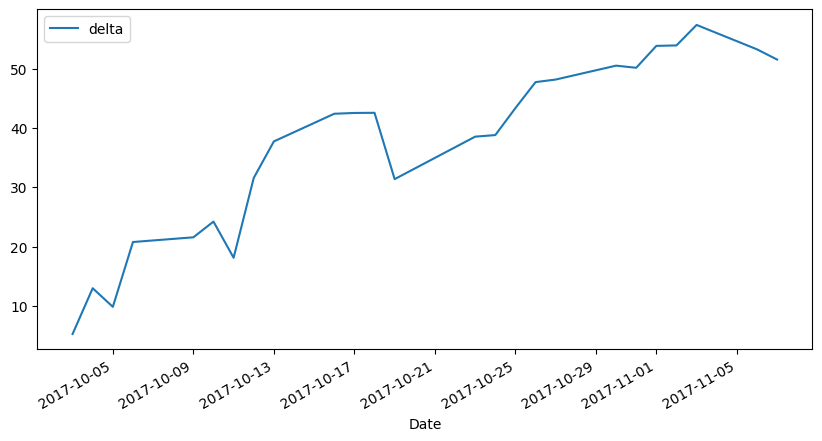

In [32]:
Nifty_Lot_Size = 75
Nifty_delta = Nifty_Opt.groupby(['Date'])['delta'].sum().to_frame() * Nifty_Lot_Size
Nifty_delta.plot(figsize=(10,5))
plt.show()

## Compute the strategy PnL

The steps followed to compute the strategy PnL are as follows:
1. PnL from the straddle (Call PnL + Put PnL)
2. PnL from the Nifty futures
3. Strategy PnL = straddle PnL + Nifty futures PnL

In [33]:
def daily_pnl(opt):
    opt['daily_pnl'] = opt.Close - opt.Close.shift(1)    
    return opt

### Call PnL

In [34]:
Nifty_CE = Nifty_Opt[Nifty_Opt['Option Type'] == 'CE'][['Date','Close']]
Nifty_CE = Nifty_CE.set_index('Date')
Nifty_CE = daily_pnl(Nifty_CE)
Nifty_CE.daily_pnl = Nifty_CE.daily_pnl * Nifty_Lot_Size
Nifty_CE.tail()

,Close,daily_pnl
Date,,
2017-11-01,655.55,7841.25
2017-11-02,635.00,-1541.25
2017-11-03,649.95,1121.25
2017-11-06,670.55,1545.00
2017-11-07,595.55,-5625.00


### Put PnL

In [35]:
Nifty_PE = Nifty_Opt[Nifty_Opt['Option Type'] == 'PE'][['Date','Close']]
Nifty_PE = Nifty_PE.set_index('Date')
Nifty_PE = daily_pnl(Nifty_PE)
Nifty_PE.daily_pnl = Nifty_PE.daily_pnl * Nifty_Lot_Size
Nifty_PE.tail()

,Close,daily_pnl
Date,,
2017-11-01,45.60,-1098.75
2017-11-02,45.45,-11.25
2017-11-03,42.95,-187.50
2017-11-06,43.75,60.00
2017-11-07,51.10,551.25


### Straddle PnL

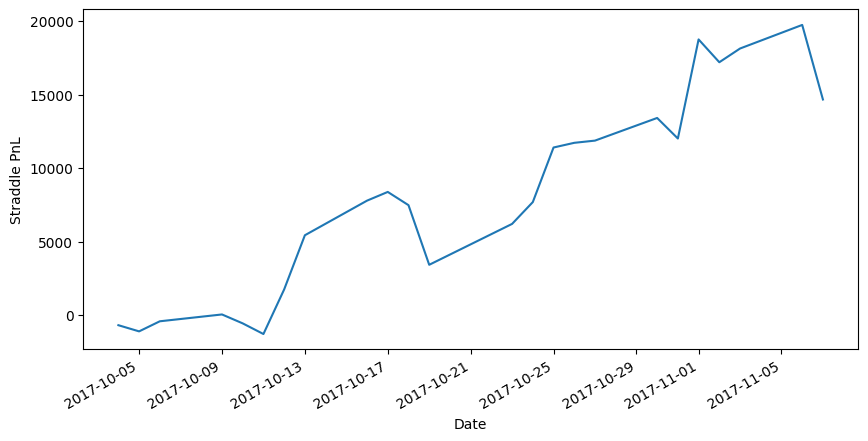

In [36]:
straddle_pnl = Nifty_CE.daily_pnl + Nifty_PE.daily_pnl
straddle_pnl.cumsum().plot(figsize=(10,5))
plt.ylabel("Straddle PnL")
plt.show()

### Nifty futures PnL

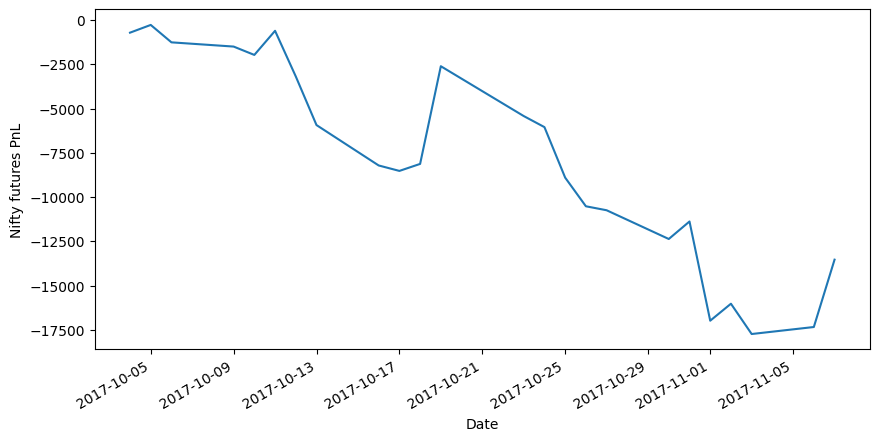

In [37]:
Nifty_Fut = Nifty_Opt.groupby(['Date'])['futures_price'].first().to_frame()
Nifty_Fut = Nifty_Fut.rename(columns={'futures_price': 'Close'})     
Nifty_Fut['quantity'] = -Nifty_delta // 5 * 5
Nifty_Fut = daily_pnl(Nifty_Fut)
Nifty_Fut.daily_pnl = Nifty_Fut.daily_pnl * Nifty_Fut.quantity.shift(1)
Nifty_Fut.daily_pnl.cumsum().plot(figsize=(10,5))
plt.ylabel("Nifty futures PnL")
plt.show()


### Strategy PnL

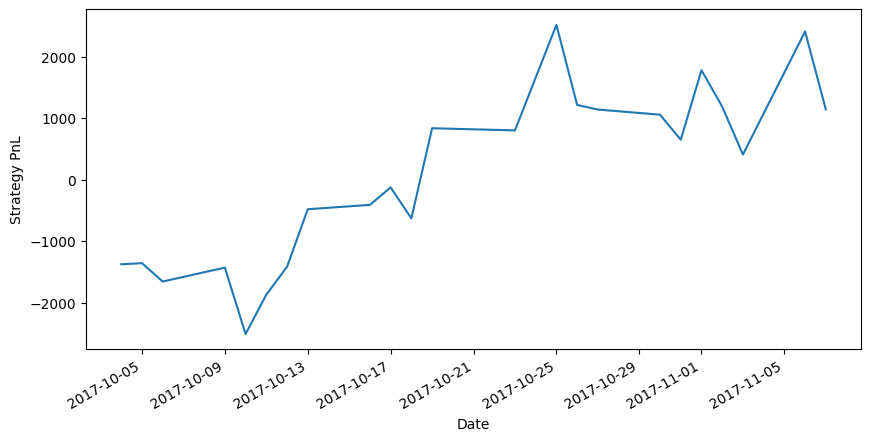

In [38]:
strategy_pnl = Nifty_CE.daily_pnl + Nifty_PE.daily_pnl + Nifty_Fut.daily_pnl
strategy_pnl.cumsum().plot(figsize=(10,5))
plt.ylabel("Strategy PnL")
plt.show()

In this example, Gamma scalping showed that money could be made. We made INR 1000 through this strategy. There are many more factors that influence the strategy’s profitability; however, this is a basic depiction of the power of Gamma scalping.
In the next unit, there will be an interactive exercise.
<BR>